In [88]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import numpy as np

In [3]:
from utils.utils import load_data

FOLDER_PATH = "sentiment_datasets/projekt2_data"

data_df = load_data(FOLDER_PATH, df_delimiter=",")
data_df.head(10)

,SentenceId,Phrase,Sentiment,df_
0,8068,feminist conspiracy theorist,2,2
1,8068,conspiracy theorist,2,2
2,8068,theorist,2,2
3,8068,named dirty dick,2,2
4,8068,dirty dick,2,2
5,8069,"the aaa of action, xxx is a blast of adrenalin...",4,2
6,8069,the aaa of action,3,2
7,8069,the aaa,2,2
8,8069,aaa,2,2
9,8069,", xxx is a blast of adrenalin, rated eee for e...",4,2


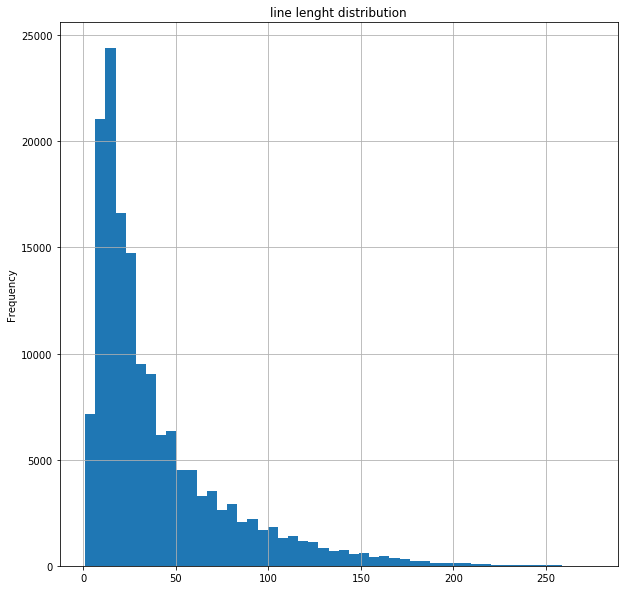

In [4]:
data_df["Phrase"].str.len().plot(kind="hist", title="line lenght distribution", grid=True, figsize=(10,10), bins=50);

# Character Level RNN

In [5]:
from preprocess_data.preprocess_data import preprocess_data_char
from architecture.models import model_rnn
from utils.utils_result import save_report, update_fit_params, evaluation

W0523 17:27:15.117297 140270132172608 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [6]:
# preprocess data
(x_train, y_train), (x_val, y_val), (x_test, y_test), int2char = preprocess_data_char(data_df, x_label="Phrase", y_label="Sentiment", max_len_seq=None)

In [7]:
# general parameter setting
tensorboard_params = {
    "histogram_freq": 1,
    "write_graph": True,
    "write_images": True
}

fit_params = {
    "x": x_train,
    "y": y_train,
    "epochs": 50,
    "batch_size": 64,
    "validation_data": (x_val, y_val) 
}

input_params = {
    "shape": x_train.shape[1:],
    "dtype": x_train.dtype
}

test_result_dict = {}

In [8]:
VOCAB_SIZE = len(int2char)
MAX_LEN_SEQ = x_train.shape[1]
EMB_OUTPUT_DIM = min(32, VOCAB_SIZE)

## One-Hot Layer

In [9]:
# parameters setting
ohl_params = {
    "input_dim": VOCAB_SIZE
}

model_params_ohl = {
    "input_layer": "simple_input",
    "emb_layer": "OneHot",
    "input_params": input_params,
    "emb_params": ohl_params,
    "out_activation": "softmax",
    "out_units": np.unique(y_train).shape[0],
    "loss": "sparse_categorical_crossentropy",
    "optimizer": "adam"
}
model_name = "model_ohl"
model_ohl = model_rnn(model_params_ohl)
fit_params, markered_path = update_fit_params(fit_params, model_name=model_name, tensorboard_params=tensorboard_params)

Instructions for updating:
Colocations handled automatically by placer.


W0523 17:27:20.342997 140270132172608 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:423: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0523 17:27:20.352068 140270132172608 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/core.py:143: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 139999 samples, validate on 7800 samples
Instructions for updating:
Use tf.cast instead.


W0523 17:27:21.812876 140270132172608 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


W0523 17:27:21.909545 140270132172608 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Epoch 1/50
139999/139999 [==============================] - 696s 5ms/sample - loss: 1.2518 - acc: 0.5044 - val_loss: 1.2359 - val_acc: 0.4903
Epoch 2/50
139999/139999 [==============================] - 688s 5ms/sample - loss: 1.2043 - acc: 0.5176 - val_loss: 1.2721 - val_acc: 0.4871
Epoch 3/50
139999/139999 [==============================] - 689s 5ms/sample - loss: 1.1949 - acc: 0.5201 - val_loss: 1.2300 - val_acc: 0.4950
Epoch 4/50
139999/139999 [==============================] - 695s 5ms/sample - loss: 1.1845 - acc: 0.5243 - val_loss: 1.2023 - val_acc: 0.5045
Epoch 5/50
139999/139999 [==============================] - 691s 5ms/sample - loss: 1.1759 - acc: 0.5270 - val_loss: 1.2426 - val_acc: 0.4938
Epoch 6/50
139999/139999 [==============================] - 691s 5ms/sample - loss: 1.1647 - acc: 0.5308 - val_loss: 1.2180 - val_acc: 0.5056
Epoch 7/50
139999/139999 [==============================] - 693s 5ms/sample - loss: 1.1561 - acc: 0.5336 - val_loss: 1.2135 - val_acc: 0.5085
Epoch 

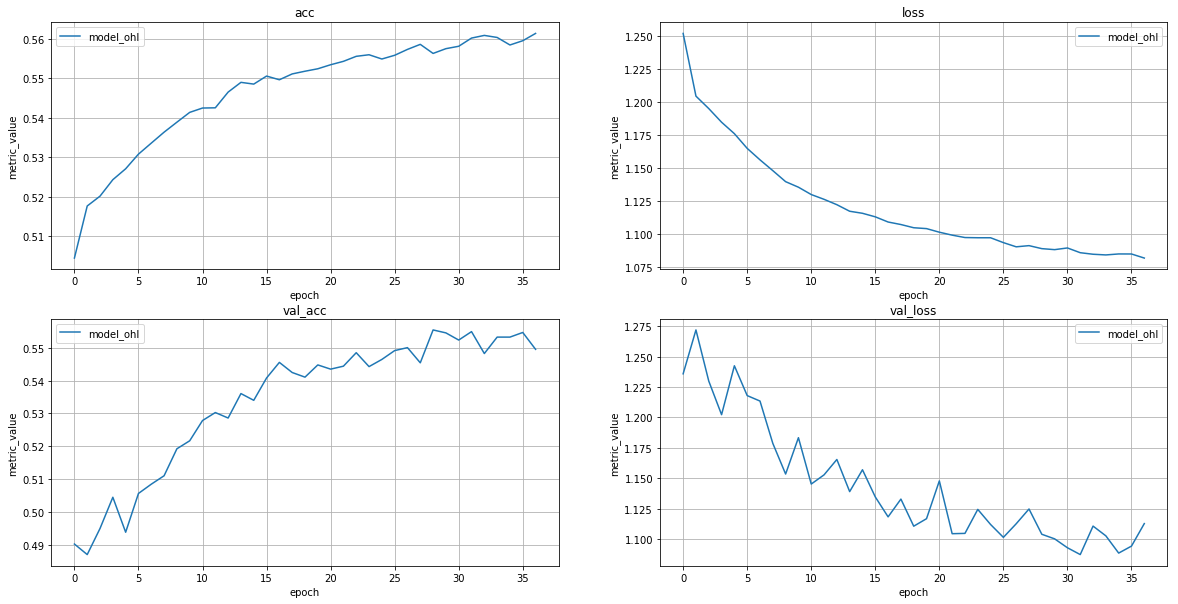

In [10]:
# training
model_ohl.fit(**fit_params);
model_ohl = save_report(model_ohl, model_name=model_name, markered_path=markered_path)

In [11]:
# evaluation
test_result_dict = evaluation(model=model_ohl, x_test=x_test, y_test=y_test, model_name=model_name, test_result_dict=test_result_dict)

Wynik na zbiorze testowym modelu model_ohl, to 0.5556


## Embedding Layer

In [12]:
# parameters setting
el_params = {
    "input_dim": VOCAB_SIZE,
    "output_dim": EMB_OUTPUT_DIM,
    "input_length": MAX_LEN_SEQ,
    "trainable": True
}

model_params_el = {
    "input_layer": "simple_input",
    "emb_layer": "Embedding",
    "input_params": input_params,
    "emb_params": el_params,
    "out_activation": "softmax",
    "out_units": np.unique(y_train).shape[0],
    "loss": "sparse_categorical_crossentropy",
    "optimizer": "adam"
}
model_name = "model_el"
model_el = model_rnn(model_params_el)
fit_params, markered_path = update_fit_params(fit_params, model_name=model_name, tensorboard_params=tensorboard_params)

Train on 139999 samples, validate on 7800 samples
Epoch 1/50
139999/139999 [==============================] - 777s 6ms/sample - loss: 1.1962 - acc: 0.5193 - val_loss: 1.2118 - val_acc: 0.4958
Epoch 2/50
139999/139999 [==============================] - 784s 6ms/sample - loss: 1.1822 - acc: 0.5245 - val_loss: 1.2067 - val_acc: 0.5072
Epoch 3/50
139999/139999 [==============================] - 772s 6ms/sample - loss: 1.1670 - acc: 0.5295 - val_loss: 1.1743 - val_acc: 0.5156
Epoch 4/50
139999/139999 [==============================] - 792s 6ms/sample - loss: 1.1505 - acc: 0.5360 - val_loss: 1.1546 - val_acc: 0.5221
Epoch 5/50
139999/139999 [==============================] - 739s 5ms/sample - loss: 1.1340 - acc: 0.5416 - val_loss: 1.1496 - val_acc: 0.5271
Epoch 6/50
139999/139999 [==============================] - 785s 6ms/sample - loss: 1.1211 - acc: 0.5462 - val_loss: 1.1358 - val_acc: 0.5304
Epoch 7/50
139999/139999 [==============================] - 760s 5ms/sample - loss: 1.1084 - acc: 

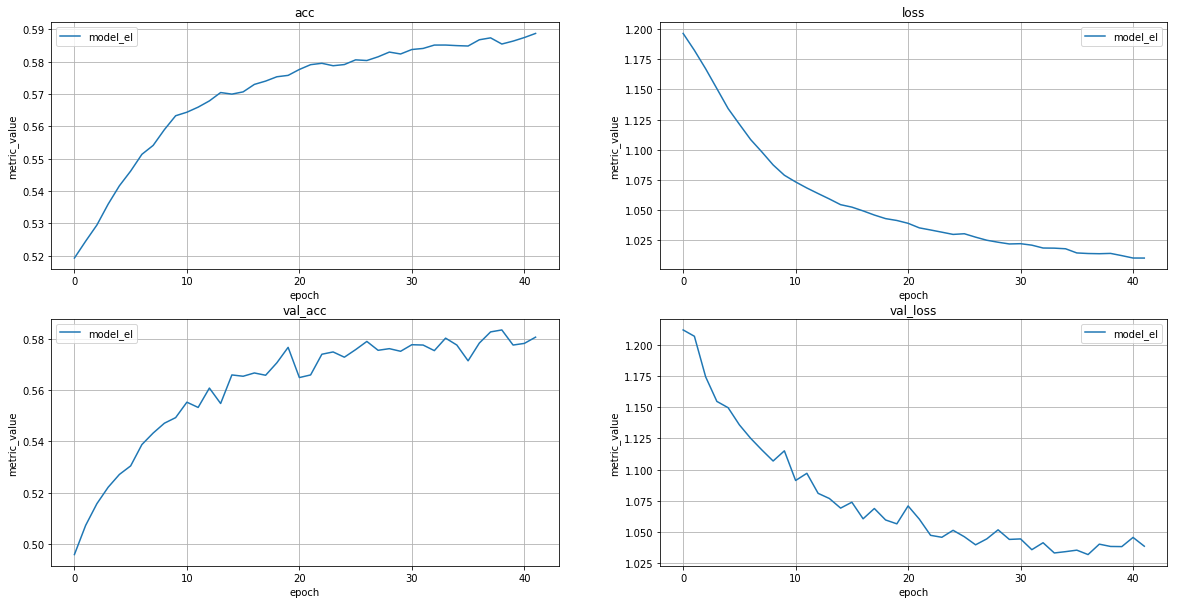

In [14]:
# training
model_el.fit(**fit_params);
model_el = save_report(model=model_el, model_name=model_name, markered_path=markered_path)

In [15]:
# evaluation
test_result_dict = evaluation(model=model_el, x_test=x_test, y_test=y_test, model_name=model_name, test_result_dict=test_result_dict)

Wynik na zbiorze testowym modelu model_el, to 0.5741


# Results

In [71]:
test_result_dict

{'model_ohl': 0.5556410256410257, 'model_el': 0.5741025641025641}

In [91]:
from utils.utils_result import update_common_history_folder, display_results

['model_ohl' 'model_el']


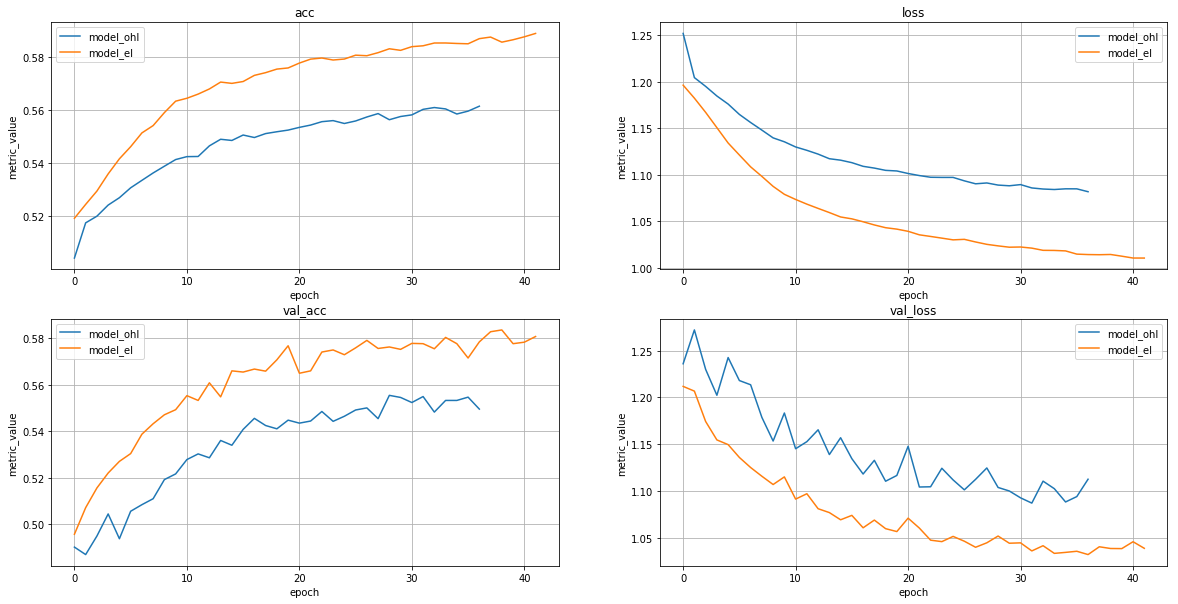

In [92]:
update_common_history_folder("about_model")
display_results("about_models/comparision")